In [16]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, Lars, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

import utils

import warnings
warnings.filterwarnings('ignore')

In [17]:
dataframe = pd.read_csv("house_price.csv")
OUTPUT_COLUMN = 'Цена'

# Категориальные признаки уже закодированы, однако всё еще необходимо удалить по одному столбцу для каждого закодированного признака
feature_groups = [['Без.ремонта', 'Дизайнерский', 'Евроремонт', 'Косметический'],
                  ['Балкон', 'Лоджия'], 
                  ['Железобетонные.перекрытия', 'Смешанные.перекрытия','Деревянные.перекрытия', 'Иные.перекрытия'],
                  ['Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Смешанные.стены']]
to_drop = [group[-1] for group in feature_groups]

feature_groups = [group[:-1] for group in feature_groups]
numeric = ['Количество.комнат', 'Общая.площадь', 'Этаж', 'Этажей.в.доме','Школа.1000', 'ВУЗ.1000',
       'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000',
       'Парк.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000',
       'Кинотеатр.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000',
       'Бар.1000', 'Банк.1000', 'Аптека.1000']



# Сохраняем оставшиеся категориальные данные
categorical = []

[categorical.extend(group)for group in feature_groups]

dataframe = utils.preprocess_df(dataframe, OUTPUT_COLUMN, categorical, numeric, to_drop=to_drop)
dataframe.head(5)


,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Совмещенный.санузел,Раздельный.санузел,Лифт,...,Балкон_3,Балкон_4,Железобетонные.перекрытия_1,Смешанные.перекрытия_1,Деревянные.перекрытия_1,Панельные.стены_1,Блочные.стены_1,Деревянные.стены_1,Кирпичные.стены_1,Монолитные.стены_1
0,896,0.25,0,0.327273,0.117647,0.125000,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,399,0.25,0,0.314545,0.235294,0.125000,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1515,0.25,0,0.390909,0.000000,0.291667,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,677,0.00,0,0.211818,0.000000,0.333333,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1485,0.00,0,0.318182,0.411765,0.291667,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])

In [19]:
# R2 метрика каждого из методов.
# Полиномиальная регрессия - лучший результат из предыдущей работы
results = {"Полиномиальная регрессия": 0.92}

# Одиночное дерево решений

In [20]:
reg_tree = DecisionTreeRegressor()
params = {"criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"], "splitter": ["best", "random"]}
reg_tree = utils.grid_search(reg_tree, params, x_train, y_train)
predicted = reg_tree.predict(x_test)
metrics = utils.get_regression_metrics(y_test, predicted)
results['Дерево решений'] = metrics['R2']

In [21]:
# Обрезка дерева
# Обрезка дерева
ccp_alphas = reg_tree.cost_complexity_pruning_path(x_train, y_train).ccp_alphas
best_accuracy = 0
for alpha in ccp_alphas:
    pruned_reg = DecisionTreeRegressor()
    pruned_reg.set_params(**reg_tree.get_params())
    pruned_reg.set_params(**{"ccp_alpha": alpha})
    pruned_reg.fit(x_train, y_train)
    accuracy = utils.get_regression_metrics(y_test, pruned_reg.predict(x_test))['R2']
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_alpha = alpha
        pruned_tree_reg = pruned_reg
#pruned_tree_clf = best_clf
metrics = utils.get_regression_metrics(y_test, pruned_tree_reg.predict(x_test))
results['Обрезанное дерево решений'] = metrics['R2']

In [22]:
results

{'Полиномиальная регрессия': 0.92,
 'Дерево решений': 0.8666358259734659,
 'Обрезанное дерево решений': 0.8876396444620717}

# Бэггинг

In [23]:
# Использует обрезанное дерево из предыдущего раздела
params = {'n_estimators': range(3, 11)}
bagging_clf = utils.grid_search(BaggingRegressor(pruned_tree_reg), params, x_train, y_train)
predicted = bagging_clf.predict(x_test)
metrics = utils.get_regression_metrics(y_test, predicted)
results['Бэггинг'] = metrics['R2']

# Бустинг

In [24]:
params = {'learning_rate': [x/100 for x in range(1, 110, 20)], 'n_estimators': range(20, 200, 40),}
boosting_reg = utils.grid_search(GradientBoostingRegressor(), params, x_train, y_train)
predicted = boosting_reg.predict(x_test)
metrics = utils.get_regression_metrics(y_test, predicted)
results['Бустинг'] = metrics['R2']

# Стекинг

In [25]:
# Включает в себя модели из предыдущей работы, а также обрезанное дерево решений, полученное выше
# Модели и их параметры из предыдущей работы
models_data = [{"name": "Linear", "model": LinearRegression(), "params": {'n_jobs': range(1, 11)}},
               {"name": "Lasso", "model": Lasso(), "params": {'alpha': range(1, 10)}},
               {"name": "Ridge", "model": Ridge(), "params": {'alpha': range(1, 10), 'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}},
               #{"name": "SVR", "model": SVR(), "params": {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}},
               #{"name": "Bayesian", "model": BayesianRidge(), "params": {'alpha_1': [x/100000 for x in range(1, 5)], 'alpha_2': [x/100000 for x in range(1, 5)],'lambda_1': [x/100000 for x in range(1, 5)], 'lambda_2': [x/100000 for x in range(1, 5)]}},
               {"name": "Lars", "model": Lars(), "params": {}},
               #{"name": "SGDRegression", "model": SGDRegressor(), "params": {'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l1', 'l2', 'elasticnet']}},
               ]

stacking_models = [(model_data['name'], utils.grid_search(model_data['model'], model_data['params'], x_train, y_train)) for model_data in models_data]
stacking_models.append(("Pruned tree", pruned_tree_reg))
stacking_reg = StackingRegressor(stacking_models)
stacking_reg.fit(x_train, y_train)
predicted = stacking_reg.predict(x_test)
metrics = utils.get_regression_metrics(y_test, predicted)
#results['Стекинг'] = metrics['R2']

In [26]:
for item in stacking_models:
    print(utils.get_regression_metrics(y_test, item[1].predict(x_test)))

{'RMSE': 310572.215890874, 'R2': 0.9202608111341504}
{'RMSE': 310429.0663779741, 'R2': 0.9203343012587405}
{'RMSE': 332298.9320858948, 'R2': 0.9087139315009194}
{'RMSE': 2.052622378762541e+16, 'R2': -3.483090278813167e+20}
{'RMSE': 368666.13530639256, 'R2': 0.8876396444620717}


In [27]:
results['Стекинг'] = metrics['R2']

In [28]:
print(results)

{'Полиномиальная регрессия': 0.92, 'Дерево решений': 0.8666358259734659, 'Обрезанное дерево решений': 0.8876396444620717, 'Бэггинг': 0.9075819444456232, 'Бустинг': 0.920071732733174, 'Стекинг': -3.7871665427577286e+17}


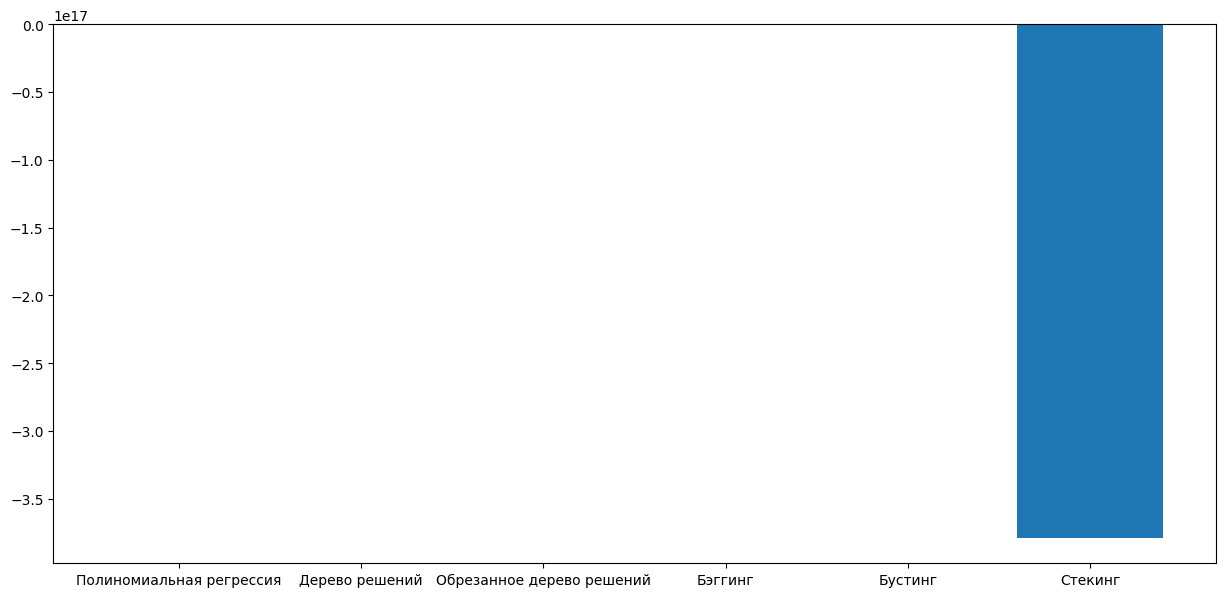

In [29]:
plt.figure(figsize=(15, 7))
plt.bar(results.keys(), results.values())
plt.show()